In [1]:
!pip install -U "tensorflow-text==2.15.*"
!pip install -U "tf-models-official==2.15.*"

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 60.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 92.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: tensorboard
    Found existing installa

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

2024-08-24 11:25:13.865353: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-24 11:25:13.865413: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-24 11:25:13.866852: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Data Import

In [3]:
df = pd.read_csv('input/imdb-dataset-csv/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Exploratory Data Analysis

In [4]:
df.groupby('sentiment').describe()

review                                                            \
           count unique                                                top   
sentiment                                                                    
negative   25000  24698  Nickelodeon has gone down the toilet. They hav...   
positive   25000  24884  Loved today's show!!! It was a variety and not...   

                
          freq  
sentiment       
negative     3  
positive     5

In [5]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [6]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [7]:
df['sentiment_num'] = df['sentiment'].apply(lambda x: 1 if x=='positive' else 0)
df.head()

,review,sentiment,sentiment_num
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


### Splitting the data into training and testing set

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment_num'], test_size=0.2, random_state=42)

In [9]:
X_train.shape

(40000,)

In [10]:
X_test.shape

(10000,)

### Load BERT Preprocessor and BERT Model

In [11]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

### Build the BERT Model

In [12]:
# Input layer
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

# Preprocess the text input
preprocessed_text = bert_preprocess(text_input)

# Encode the preprocessed text
outputs = bert_encoder(preprocessed_text)

# Apply dropout to the pooled output
l = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])

# Add a dense layer for binary calssification
l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

# Construct the final model
model = tf.keras.Model(inputs=[text_input], outputs=[l])

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_word_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

### Compile the Model

In [14]:
Metrics = [
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics=Metrics)

### Train the Model

In [15]:
model.fit(X_train,y_train,epochs=10)

Epoch 1/10
   1/1250 [..............................] - ETA: 3:53:30 - loss: 0.7352 - binary_accuracy: 0.5312 - precision: 0.5312 - recall: 1.0000

I0000 00:00:1724498869.176444     166 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 [==============================] - 423s 330ms/step - loss: 0.6057 - binary_accuracy: 0.6713 - precision: 0.6754 - recall: 0.6570
Epoch 2/10
1250/1250 [==============================] - 418s 334ms/step - loss: 0.5490 - binary_accuracy: 0.7236 - precision: 0.7280 - recall: 0.7125
Epoch 3/10
1250/1250 [==============================] - 418s 334ms/step - loss: 0.5290 - binary_accuracy: 0.7388 - precision: 0.7437 - recall: 0.7273
Epoch 4/10
1250/1250 [==============================] - 418s 334ms/step - loss: 0.5212 - binary_accuracy: 0.7437 - precision: 0.7487 - recall: 0.7321
Epoch 5/10
1250/1250 [==============================] - 418s 334ms/step - loss: 0.5159 - binary_accuracy: 0.7465 - precision: 0.7512 - recall: 0.7357
Epoch 6/10
1250/1250 [==============================] - 418s 334ms/step - loss: 0.5112 - binary_accuracy: 0.7511 - precision: 0.7569 - recall: 0.7384
Epoch 7/10
1250/1250 [==============================] - 418s 334ms/step - loss: 0.5113 - binary_accuracy: 0.751

### Evalute the Model


In [16]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 106s 335ms/step - loss: 0.4785 - binary_accuracy: 0.7732 - precision: 0.8123 - recall: 0.7152


[0.4784933626651764,
 0.7731999754905701,
 0.8122605085372925,
 0.7152212858200073]

### Make Predictions

In [17]:
y_predicted = model.predict(X_test)

313/313 [==============================] - 105s 332ms/step


In [18]:
y_predicted = (y_predicted > 0.5).astype(int).flatten()

In [19]:
# Classification Report
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.74      0.83      0.78      4961
           1       0.81      0.72      0.76      5039

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000



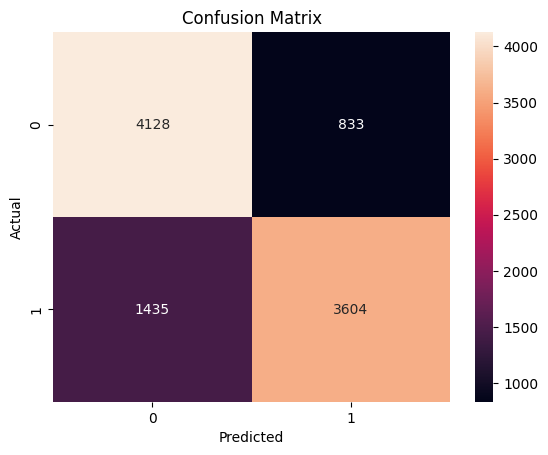

In [20]:
# Confusion matrix
cm = confusion_matrix(y_test, y_predicted)
sns.heatmap(cm, annot=True,fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

